In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import gc
import warnings
from joblib import dump, load
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
def load_data():
    data = pd.read_csv('cleaned_data.csv', names=['Review','Sentiment','Sentence_Removal','Lower_Case','Sen_Out_StopWord','stem'])
    return data

In [4]:
roman_urdu_df= load_data()
roman_urdu_df.head()

,Review,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
0,Reviews,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
1,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,Sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha her kisi kay bus bat nhi lakin ki hal ...,sae qa er qisi qay bos bat ni laqin qi al qal ...
2,sahi bt h,Positive,sahi bt h,sahi bt h,sahi bt h,sai bt
3,"Kya bt hai,",Positive,Kya bt hai,kya bt hai,bt,bt
4,Wah je wah,Positive,Wah je wah,wah je wah,wah je wah,wa je wa


In [5]:
roman_urdu_df = roman_urdu_df.drop(roman_urdu_df.index[0])
roman_urdu_df = roman_urdu_df.reset_index(drop=True)
roman_urdu_df.head()

,Review,Sentiment,Sentence_Removal,Lower_Case,Sen_Out_StopWord,stem
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,Sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha ya her kisi kay bus ki bat nhi hai lak...,sai kha her kisi kay bus bat nhi lakin ki hal ...,sae qa er qisi qay bos bat ni laqin qi al qal ...
1,sahi bt h,Positive,sahi bt h,sahi bt h,sahi bt h,sai bt
2,"Kya bt hai,",Positive,Kya bt hai,kya bt hai,bt,bt
3,Wah je wah,Positive,Wah je wah,wah je wah,wah je wah,wa je wa
4,Are wha kaya bat hai,Positive,Are wha kaya bat hai,are wha kaya bat hai,are wha kaya bat,are wa qaya bat


In [6]:
roman_urdu_df=roman_urdu_df.dropna()
print(roman_urdu_df.isna().any())

Review              False
Sentiment           False
Sentence_Removal    False
Lower_Case          False
Sen_Out_StopWord    False
stem                False
dtype: bool


In [7]:
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator of K folds
    cv = KFold(n_splits=K, random_state=0, shuffle=True)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print("Mean score: %.3f (+/-%.3f)" % (np.mean(scores), sem(scores)))

In [8]:
def calc_params(X, y, clf, param_values, param_name, K):

    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))

    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})

        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)

        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)

        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1

        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "Train =", train_scores[i], "Test =", test_scores[i])

    # plot the training and testing scores in a log scale
    plt.semilogx(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.semilogx(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

In [8]:
X = roman_urdu_df['stem']
y = roman_urdu_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [9]:
tfidf = TfidfVectorizer(lowercase=False)
X_tfidf = tfidf.fit_transform(X_train.values.astype('U'))
X_tfidf.shape
X_test_tfidf = tfidf.transform(X_test.values.astype('U'))
X_test_tfidf.shape
X_tfidf

<27149x33384 sparse matrix of type '<class 'numpy.float64'>'
	with 281023 stored elements in Compressed Sparse Row format>

[0.58305709 0.58950276 0.59208103 0.58987109 0.578007  ]
Mean score: 0.587 (+/-0.003)
[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]
nb__alpha = 0.01 Train = 0.9036244414998638 Test = 0.5865037939962965
nb__alpha = 0.01438449888287663 Train = 0.9022984292847441 Test = 0.588566456588263
nb__alpha = 0.0206913808111479 Train = 0.900825079364191 Test = 0.5904818166676673
nb__alpha = 0.029763514416313176 Train = 0.8986518902876071 Test = 0.5934284978664814
nb__alpha = 0.04281332398719394 Train = 0.8957788510318935 Test = 0.5961542049433046
nb__alpha = 0.06158482110660264 Train = 0.8917087252998854 Test = 0.5983642378916582
nb__alpha = 0.08858667904100823 Train = 0.8864046611766547 Test = 0.6010162665746704
nb__alpha = 0.12742749857031335 Train = 0.8797377418266479 Test = 0.6033735884668212
nb__al

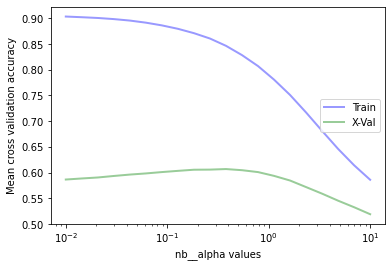

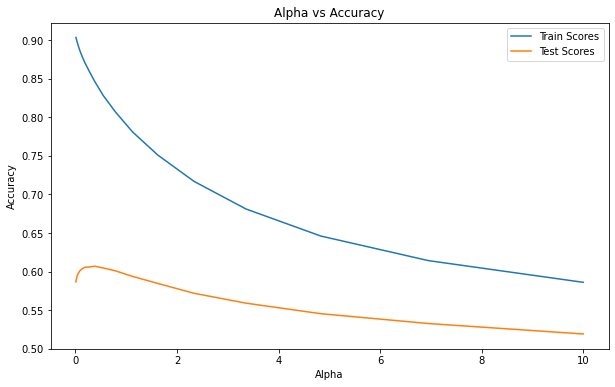

Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.46      0.54      1830
     Neutral       0.58      0.60      0.59      2392
    Positive       0.64      0.75      0.69      2566

    accuracy                           0.62      6788
   macro avg       0.62      0.60      0.61      6788
weighted avg       0.62      0.62      0.61      6788

Accuracy: 0.619
Precision: 0.621
Recall: 0.619
F1 Score: 0.614


Text(51.0, 0.5, 'True')

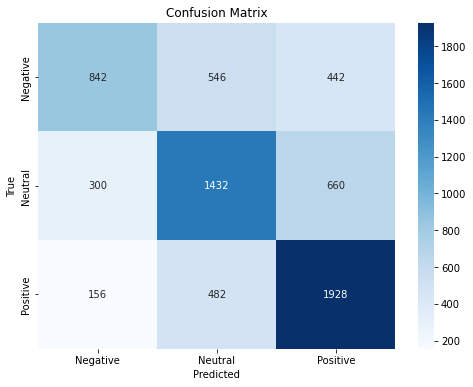

In [10]:


from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('nb', MultinomialNB(alpha=0.01)),
])
evaluate_cross_validation(clf, X_train, y_train, 5)
alphas = np.logspace(-2, 1, 20)
print(alphas)
# to calculate train-scores and test_scores calling calc_params function from above by passing the parameters:
# X_train, #y_train, multinominalNB, alphas value
train_scores, test_scores = calc_params(X_train, y_train, clf, alphas, 'nb__alpha', 5)
best_alpha = alphas[np.argmax(test_scores)]
mnb = MultinomialNB(alpha= best_alpha)
mnb.fit(X_tfidf, y_train)
### Performance on the test data
y_pred = mnb.predict(X_test_tfidf)
print(classification_report(y_pred, y_test))


# Plot the train-scores and test_scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_scores, label='Train Scores')
plt.plot(alphas, test_scores, label='Test Scores')
plt.title('Alpha vs Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

# Plot a confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')